# CS541: Applied Machine Learning, Spring 2025, Lab 8

Lab 8 is an exercise that explores Convolutional Neural Networks (CNNs). Convolutional Neural Network (CNN) is the extended version of artificial neural networks (ANN) which is predominantly used to extract the feature from the grid-like matrix dataset. For example visual datasets like images or videos where data patterns play an extensive role. They utilize layers like convolutional layers, transposed convolution layers and pooling layers. They can perform tasks such as semantic segmentation, instance segmentation, image classification and detection and to name a few.

**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm
import time

import torchvision.models as models # contains a lot of pretrained models you can use.
# https://pytorch.org/vision/stable/models.html

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

In [2]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.5.2
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.14
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              4.9.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.7.1
arviz                              0.21.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.17.0.34.53
astunparse                         1.6.3
atpublic                           5.1
attrs                              25.3.0
audioread            

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=False, num_workers=2)



testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:18<00:00, 9.07MB/s]


In [4]:

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 7, padding="same") # inchannel, outchannel, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.fc3 = nn.Linear(2560, 10)  # Adjust the output classes accordingly

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # this is a square output
        x = x.view(x.shape[0], -1)  # Adjust the feature map size accordingly
        x = self.fc3(x)
        return x

# Initialize the network
net = SimpleCNN().to(device)

# Define the loss function and optimizer, we don't use momentum here
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)

# Training the network
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader, 0)):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

correct = 0
total = 0
avg_time = []
for data in testloader:
    images, labels = data
    start = time.time()
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    end = time.time()
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()
    time_taken = end - start
    avg_time.append(time_taken)

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
print(f"Avg time taken for prediction: {np.average(avg_time)}")

2059it [00:13, 244.10it/s]

[1,  2000] loss: 2.017


4055it [00:20, 339.62it/s]

[1,  4000] loss: 1.809


6046it [00:26, 334.51it/s]

[1,  6000] loss: 1.670


8053it [00:33, 340.02it/s]

[1,  8000] loss: 1.605


10055it [00:39, 342.61it/s]

[1, 10000] loss: 1.570


12049it [00:45, 333.29it/s]

[1, 12000] loss: 1.517


12500it [00:47, 265.32it/s]


Accuracy of the network on the 10000 test images: 48.28%
Avg time taken for prediction: 0.0005658499717712402


### Here we want to add momentum for our Optimizer and we can we it helps our classification results

In [5]:
# Initialize the network
net = SimpleCNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader, 0)):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

correct = 0
total = 0
avg_time = []
for data in testloader:
    images, labels = data
    start = time.time()
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    end = time.time()
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()
    time_taken = end - start
    avg_time.append(time_taken)

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
print(f"Avg time taken for prediction: {np.average(avg_time)}")

2049it [00:07, 305.93it/s]

[1,  2000] loss: 1.773


4029it [00:14, 204.51it/s]

[1,  4000] loss: 1.586


6058it [00:21, 300.04it/s]

[1,  6000] loss: 1.472


8039it [00:28, 310.76it/s]

[1,  8000] loss: 1.423


10019it [00:35, 188.31it/s]

[1, 10000] loss: 1.443


12027it [00:42, 325.25it/s]

[1, 12000] loss: 1.394


12500it [00:44, 283.83it/s]


Accuracy of the network on the 10000 test images: 53.95%
Avg time taken for prediction: 0.000561996841430664


## Let's visualize what the filters are learning for our task:

conv1.weight


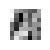

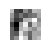

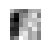

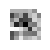

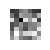

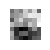

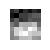

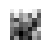

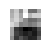

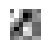

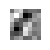

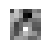

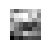

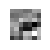

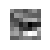

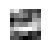

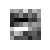

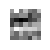

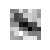

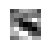

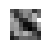

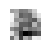

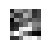

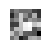

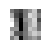

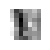

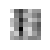

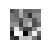

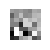

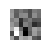

In [6]:
# Visualize weights as images
def imshow(img):
    plt.figure(figsize=(0.4, 0.4))
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.show()

# Get the weights
for name, param in net.named_parameters():
    if 'weight' in name:
        weights = param.data.cpu()
        # Visualize the weights as images
        if len(weights.size()) == 4:  # Convolutional layer
            print(name)
            for i in range(weights.size(0)):
                for j in range(weights.size(1)):
                  imshow(weights[i,j])



## Let's play with some common pretrained deep nets

Resnets are a class of famous conv nets that worked accurately on a range os classification tasks.

The key idea in resnet's was residual connections that enabled training of very deep networks.

We shall see how the deeper a network, the better the accuracy at the cost of computation.

A common theme in the 2016-18 times was to use pretrained features from Renset for various custom tasks on custom datasets.

Your challenge would be to extract the last layer features from the resnet and train it on CIFAR 10 to improve performance.

### Pretrained models are trained with a specific image preprocessing.

Hence, we must take care to preprocess the image the same way.



In [7]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()
# Initialize the inference transforms
preprocess = weights.transforms()
print(preprocess)
# Apply inference preprocessing transforms to the dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=preprocess)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=False, num_workers=2)



testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### However, there is a challenge.

We cannot apply this network directly to CIFAR 10 for instance, since the output of the pretrained network is 1000 classes (for imagenet), and we only have 10 classes in CIFAR 10.

Hence, we need to adapt it.

## Challenge 1: Extract the last feature and train a net on top on CIFAR 10

In [8]:
!pip install torchinfo

In [9]:
!pip install torchsummary

In [10]:
from torchsummary import summary
model1 = models.resnet18(pretrained=True).to(device)
#model1.eval()
summary(model1, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

newmodel = models.resnet18(pretrained=True).to(device)
newmodel.eval()

# step 1: make a new network that will replace the resnet head, you can add more layers if you like and compare the results
out_dim = 512
class MyNewResnet(nn.Module):
  def __init__(self):
        super(MyNewResnet, self).__init__()
        #Create a linear layer with the input being the output dimension size and the output size being the number of classes in CIFAR-10
        self.fc3 = nn.Linear(out_dim, 10)

  def forward(self, x):
      x = self.fc3(x)
      return x


new_resnet = MyNewResnet().to(device)
#This replaces the Resnet classification head with our fully connected layer
newmodel.fc = new_resnet

#Here we freeze the previous layers in ResNet and only update the parameters in the final fully connected layer
for param in newmodel.parameters():
    param.requires_grad = False
for param in newmodel.fc.parameters():
  param.requires_grad = True


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(newmodel.parameters(), lr=0.001, momentum=0.9)

# step 3: train this new network on CIFAR 10
# Training the network
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader, 0)):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = newmodel(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


# step 4: test the accuracy
correct = 0
total = 0
avg_time = []
for data in testloader:
    images, labels = data
    start = time.time()
    #outputs = newmodel(images.cuda())
    outputs = newmodel(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    end = time.time()
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()
    time_taken = end - start
    avg_time.append(time_taken)

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
print(f"Avg time taken for prediction: {np.average(avg_time)}")




2011it [00:35, 84.15it/s]

[1,  2000] loss: 0.714


4009it [01:02, 81.12it/s]

[1,  4000] loss: 0.543


6013it [01:29, 65.26it/s]

[1,  6000] loss: 0.519


8015it [01:58, 67.34it/s]

[1,  8000] loss: 0.507


10011it [02:26, 80.96it/s]

[1, 10000] loss: 0.508


12010it [02:53, 80.73it/s]

[1, 12000] loss: 0.472


12500it [03:00, 69.18it/s]


Accuracy of the network on the 10000 test images: 84.37%
Avg time taken for prediction: 0.005863463020324707


# Here we are simply increasing the number of epochs to see if it improves performance

In [12]:
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

newmodel = models.resnet18(pretrained=True).to(device)
newmodel.eval()

# step 1: make a new network that will replace the resnet head, you can add more layers if you like and compare the results
out_dim = 512
class MyNewResnet(nn.Module):
  def __init__(self):
        super(MyNewResnet, self).__init__()

        #Create a linear layer with the input being the output dimension size and the output size being the number of classes in CIFAR-10
        self.fc3 = nn.Linear(out_dim, 10)

  def forward(self, x):
      x = self.fc3(x)
      return x


new_resnet = MyNewResnet().to(device)
#This replaces the Resnet classification head with our fully connected layer
newmodel.fc = new_resnet
#print(new_resnet)
for param in newmodel.parameters():
    param.requires_grad = False
for param in newmodel.fc.parameters():
  param.requires_grad = True


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(newmodel.parameters(), lr=0.001, momentum=0.9)

# step 3: train this new network on CIFAR 10
# Training the network
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader, 0)):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = newmodel(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


# step 4: test the accuracy
correct = 0
total = 0
avg_time = []
for data in testloader:
    images, labels = data
    start = time.time()
    outputs = newmodel(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    end = time.time()
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()
    time_taken = end - start
    avg_time.append(time_taken)

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
print(f"Avg time taken for prediction: {np.average(avg_time)}")




2013it [00:36, 78.78it/s]

[1,  2000] loss: 0.711


4009it [01:03, 81.26it/s]

[1,  4000] loss: 0.544


6011it [01:31, 78.45it/s]

[1,  6000] loss: 0.517


8013it [01:59, 61.88it/s]

[1,  8000] loss: 0.506


10013it [02:27, 82.28it/s]

[1, 10000] loss: 0.507


12009it [02:54, 80.97it/s]

[1, 12000] loss: 0.473


12500it [03:02, 68.65it/s]
2013it [00:27, 75.35it/s]

[2,  2000] loss: 0.455


4011it [00:55, 81.27it/s]

[2,  4000] loss: 0.471


6013it [01:23, 77.34it/s]

[2,  6000] loss: 0.463


8009it [01:52, 73.55it/s]

[2,  8000] loss: 0.466


10016it [02:20, 79.89it/s]

[2, 10000] loss: 0.472


12011it [02:48, 77.04it/s]

[2, 12000] loss: 0.442


12500it [02:55, 71.27it/s]
2012it [00:27, 81.97it/s]

[3,  2000] loss: 0.434


4014it [00:55, 79.13it/s]

[3,  4000] loss: 0.453


6012it [01:23, 76.16it/s]

[3,  6000] loss: 0.446


8015it [01:52, 75.00it/s]

[3,  8000] loss: 0.451


10010it [02:19, 77.80it/s]

[3, 10000] loss: 0.457


12014it [02:47, 77.40it/s]

[3, 12000] loss: 0.427


12500it [02:54, 71.62it/s]


Accuracy of the network on the 10000 test images: 85.42%
Avg time taken for prediction: 0.00627890625


### Challenge : Repeat the same for ResNet 50 and observe the change in accuracy! :p

### Misc Notes:

Fore more state-of-the art models, refer to Huggingface. https://huggingface.co/models

https://www.cs.cmu.edu/~epxing/Class/10708-19/notes/lecture-16/ - CNN section.
https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf - NeurIPS paper that showed feature hierarchy in CNN's.



